# LAB 2 - MLP per problemi di riconoscimento immagini
I problemi di computer vision in generale sono molto più complessi rispetto alla mera previsione di un valore data una breve successione di numeri reali.

In questo laboratorio guidato vedremo come una rete neurale può essere addestrata a risolvere un problema di classificazione multiclasse (>2 classi). Le classi sono 10 e dovremo addestare la rete a riconoscere immagini di abbigliamento utilizzando un dataset con 10 classi.

Il dataset utilizzato è il [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).

## Codice

Importiamo le librerie che ci servono: 
* tensorFlow per creare e addestare il modello.
* numpy per gestire facilmente array e matrici.
* matplotlib per disegnare agilmente grafici dei dati e dei risultati.
* time per misurare i tempi di elaborazione

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

## Fashion MNIST Dataset

Il [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) è una collezione di immagini in scala di grigi con dimensioni di 28x28 pixel, raffiguranti capi di abbigliamento. Ogni immagine è associata a un'etichetta, come illustrato nella seguente tabella:

| Etichetta | Descrizione         |
| --------- | ------------------- |
| 0         | Maglietta/top       |
| 1         | Pantaloni           |
| 2         | Pullover            |
| 3         | Vestito             |
| 4         | Cappotto            |
| 5         | Sandali             |
| 6         | Camicia             |
| 7         | Scarpe da ginnastica |
| 8         | Borsa               |
| 9         | Stivali alla caviglia |

Questo dataset è disponibile direttamente nell'API di [tf.keras.datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets) e può essere caricato in questo modo:

In [9]:
# Caricamento Fashion MNIST
fmnist = tf.keras.datasets.fashion_mnist

Con `load_data()` possiamo ottenere due tuple ciascuna con due liste che conterranno rispettivamente i dati di training e di test etichettati (le immagini di capi di abbigliamento).
Dividiamo il dataset in `training set` e `test set`, come visto nella teoria, per: 
* Addestrare la rete neurale sul training set, valutandone e ottimizzando automaticamente le prestazioni attraverso loss e backpropagation.
* Testare le prestazioni effettive della rete nel riconoscimento di dati nuovi che non ha mai "visto".


In [10]:
# Caricamento del training set e del test set a partire dal dataset Fashion MNIST
(training_images, training_labels), (test_images, test_labels) = fmnist.load_data()

Priva di partire con l'addestramento, visualizziamo come è fatto uno degli esempi rappresentandolo sia con un numpy array, sia mostrando la relativa immagine. È possibile scegliere quale esempio visualizzare modificando il valore della variabile `index`.

LABEL: 0

IMAGE PIXEL ARRAY:

[[  0   0   0   0   0   1   0   0   0   0  41 188 103  54  48  43  87 168 133  16   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0  49 136 219 216 228 236 255 255 255 255 217 215 254 231 160  45   0   0   0   0   0]
 [  0   0   0   0   0  14 176 222 224 212 203 198 196 200 215 204 202 201 201 201 209 218 224 164   0   0   0   0]
 [  0   0   0   0   0 188 219 200 198 202 198 199 199 201 196 198 198 200 200 200 200 201 200 225  41   0   0   0]
 [  0   0   0   0  51 219 199 203 203 212 238 248 250 245 249 246 247 252 248 235 207 203 203 222 140   0   0   0]
 [  0   0   0   0 116 226 206 204 207 204 101  75  47  73  48  50  45  51  63 113 222 202 206 220 224   0   0   0]
 [  0   0   0   0 200 222 209 203 215 200   0  70  98   0 103  59  68  71  49   0 219 206 214 210 250  38   0   0]
 [  0   0   0   0 247 218 212 210 215 214   0 254 243 139 255 174 251 255 205   0 215 217 214 208 220  95   0   0]
 [  0   0   0  45 226 214 214 215 224 205   0  42 

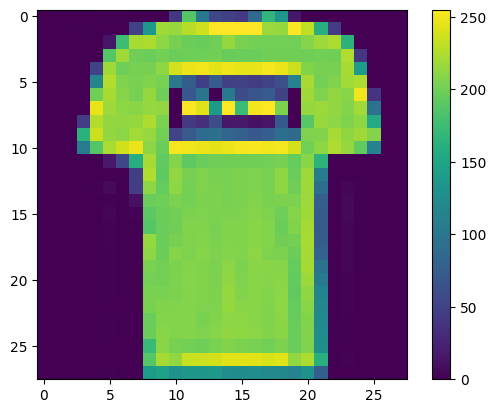

In [11]:
# Valori ammessi da 0 to 59999
index = 1

# Si imposta il numero di caratteri per riga in fase di stampa 
np.set_printoptions(linewidth=320)

# Stampo l'indice dell'etichetta
print(f'LABEL: {training_labels[index]}')
# Stampo la versione Numpy dell'immagine (una matrice di numeri che rappresentano i colori)
print(f'\nIMAGE PIXEL ARRAY:\n\n{training_images[index]}\n\n')

# Visualizzo l'immagine utilizzando la colormap predefinita (virisid)
plt.imshow(training_images[index])
plt.colorbar()
plt.show()

I valori degli input che vengono inviati ai neuroni di input del primo strato variano da 0 a 255.
Le reti neurali, in particolare quelle che si occupano di image processing, lavorano meglio con valori che variano tra 0 e 1.
È opportuno quindi _normalizzare_ questi valori in modo tale che varino in un intervallo [0..1].
Con Numpy possiamo facilmente riscalare i valori in questo modo semplicemente dividendoli per il valore massimo attuale, come di seguito.

In [12]:
# Normalizzazione dei valori dei pixel delle immagini di train e di test.
training_images  = training_images / 255.0
test_images = test_images / 255.0

Creazione di una MLP (Multilayer Perceptron) composta da 3 strati: 
1. 28 neuroni per lo strato di input (input layer): uno per ogni pixel dell'immagine che dovrà acquisire.
2. 128 neuroni per lo strato nascosto (hidden layer).
3. 10 neuroni per lo strato di outout: uno per ognuna delle tipologie di capi di abbigliamento (classi).

N.B.: una rete a 3 strati non viene ancora considerata profonda (deep), perciò formalmente non siamo ancora nell'ambito del deep learning.

In [13]:
# Creazione del modello di classificazione
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(28,28)),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

Progettiamo la rete MLP (Multilayer Perceptron) a 3 strati nel dettaglio:

[Sequential](https://keras.io/api/models/sequential/): Classe che definisce una rete neurale fatta a strati (MLP in questo caso).

[Input](https://keras.io/api/layers/core_layers/input/): Classe che definisce lo strato di input. In questo caso la forma dell'input è 28x28 neuroni per un totale di 784 neuroni, uno per ogni pixel dell'immagine.

[Flatten](https://keras.io/api/layers/reshaping_layers/flatten/): Flatten serve per "appiattire" l'immagine rappresentata da una matrice di valori, in un vettore mono-dimensionale. Questo processo è necessario perché le MLP normalmente non prevedono strati di neuroni multidimensionali, ma solo monodimensionali.
Potremmo affermare che il "flattening" in questo caso è una semplice ma fondamentale azione di `preprocessing` che serve a preparare i dati di input per la rete.

[Dense](https://keras.io/api/layers/core_layers/dense/): La classe Dense serve per crea un nuovo strato per la rete neurale. Si utilizza per creare uno strato di neuroni intermedio nascosto (`hidden layer`) nella rete MLP e il livello di uscita (`output layer`) che produce i dati in uscita.

Per gli strati intermedi e per quello di output è necessario specificare una [activation function](https://keras.io/api/layers/activations/) che ciascun neurone dello strato applicherà agli input "pesati". Ne abbiamo viste diverse, ma in questo ne usiamo una semplice e veloce da elaborare, una [ReLU](https://keras.io/api/layers/activations/#relu-function) che fa "passare" solo gli input maggiori di 0 allo strato successivo:

```
if x > 0: 
  return x

else: 
  return 0
```
Nel livello di output utilizziamo una [Softmax](https://keras.io/api/layers/activations/#softmax-function).
La Softmax è molto comoda per questo problema di classificazione multiclasse. Prende in input un vettore di valori e lo converte in un vettore di valori compresi tra [0..1] in modo tale che la loro somma sia uguale a 1. Questi valori corrispondono alla probabilità associata ad una specifica classe e il valore più alto è quello individuato dalla rete come il più probabile associato all'immagine. Ad esempio, se il valore più alto di probabilità, in output dalla rete, si trova nell'indice 6 del vettore di uscita, allora la rete ha classificato quell'immagine, in una determinata `epoca`, come una camicia. 

Maggiori dettagli sul funzionamento della funziione `Softmax` nei problemi di classificazione multiclasse può essere trovato in questa lezione di `Andrew NG` sull'argomento:(https://www.youtube.com/watch?v=LLux1SW--oM&ab_channel=DeepLearningAI) 

In [14]:
# Declare sample inputs and convert to a tensor
inputs = np.array([[1.0, 3.0, 4.0, 2.0]])
inputs = tf.convert_to_tensor(inputs)
print(f'input to softmax function: {inputs.numpy()}')

# Feed the inputs to a softmax activation function
outputs = tf.keras.activations.softmax(inputs)
print(f'output of softmax function: {outputs.numpy()}')

# Get the sum of all values after the softmax
sum = tf.reduce_sum(outputs)
print(f'sum of outputs: {sum}')

# Get the index with highest value
prediction = np.argmax(outputs)
print(f'class with highest probability: {prediction}')

input to softmax function: [[1. 3. 4. 2.]]
output of softmax function: [[0.0320586  0.23688282 0.64391426 0.08714432]]
sum of outputs: 1.0
class with highest probability: 2


Nel prossimo passaggio dobbiamo `compilare` il modello specificando alcuni importanti parametri: loss function da usare, ottimizzatore dei pesi della rete durante il backpropagation e metriche per valutare le prestazioni del nostro modello.

La configurazione ideale di una rete neurale che risolva in maniera ottimale il nostro problema non è facile da determinare.
Anche i parametri indicati sopra, possono essere modificati testando poi il comportamento della rete per verificarne le prestazioni.
Qui abbiamo scelto: 
* **Loss function** [sparse_categorial_crossentropy]`tf.keras.losses.SparseCategoricalCrossentropy()`: a differenza della più classica `categorical_crossentropy`, che richiede etichette come vettori "one hot" (come [0, 0, 1, 0, ...]) la `sparse_categorical_crossentropy` è più comoda perché può gestire direttamente etichette numeriche come (0, 1, 2, 3, ...). Inoltre è compatibile con la `Softmax` e calcola la probabilità logaritmica per la classe corretta, minimizzando la perdita tra le probabilità predette e le etichette reali.
* **Ottimizzatore** [Adam]`https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam`: è molto potente e versatile per i modelli di deep learning perché combina i vantaggi di SGD con quelli di RMSProp. Maggiori dettagli nella documentazione ufficiale.
* **Accuracy**: la metrica epsrime la percentuale di esempi classificati correttamente. Risulta intuitiva nella misurazione delle prestazioni del modello. Adatta a dataset bilanciati come quello utilizzato (MNIST).

In [15]:
model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(training_images, training_labels, epochs=5)

Epoch 1/5


2024-11-16 17:50:37.947402: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1875/1875 [==============================] - 1s 622us/step - loss: 0.5002 - accuracy: 0.8241
Epoch 2/5
1875/1875 [==============================] - 1s 629us/step - loss: 0.3752 - accuracy: 0.8644
Epoch 3/5
1875/1875 [==============================] - 1s 621us/step - loss: 0.3369 - accuracy: 0.8776
Epoch 4/5
1875/1875 [==============================] - 1s 594us/step - loss: 0.3121 - accuracy: 0.8870
Epoch 5/5
1875/1875 [==============================] - 1s 590us/step - loss: 0.2929 - accuracy: 0.8923


Durante la fase di addestramento è possibile visualizzare loss e accuracy. Già dopo sole 5 epoche è possibile ottenere un livello di accuratezza abbastanza alto, vicino a 0.9100 o superiore (91%). Questo valore significa che, alla fine dell'addestramento, il modello è in grado di riconoscere circa 91% delle immagini correttamente.

Passiamo ora alla fase di test durante la quale proveremo il nostro modello su una parte del dataset che la rete non ha mai "visto". È importante che il test set non venga mai utilizzato nella fase di addestramento, ma solo dopo aver addestrato la rete neurale ottenendo prestazioni per noi soddisfacenti.

Per lanciare la fase di test, si utilizza il metodo [`model.evaluate()`](https://keras.io/api/models/model_training_apis/#evaluate-method).
Anche in questa fase TensorFlow ci mostrerà la loss e la accuracy ottenuta.

In [16]:
# Evaluate the model on unseen data
model.evaluate(test_images, test_labels)

313/313 [==============================] - 0s 358us/step - loss: 0.3453 - accuracy: 0.8766


[0.34533563256263733, 0.8766000270843506]

L'accuratezza, con l'addestramento effettuato, arriverà a circa 0.88 o anche di più.
È evidente che le prestazioni non sono le stesse ottenute sul training set, quindi su esempi "già visti" per diverse epoche (cicli di addestramento).
Ci sono diversi modi per migliorare le prestazioni e questa è una delle fasi più divertenti della progettazione di reti neurali, il "fine tuning"!

# Esercizi

To explore further and deepen your understanding, try the exercises below:

### Esercizio 1:
Esegui il codice seguente che crea un set di valori di classificazione per ognuna delle immagini di test e, in seguito, stampa il primo risultato di classificazione. 
Cosa rappresentano i numeri stampati?

Suggerimento: prova a eseguire `print(test_labels[0])` e otterrai il numero 9.

In [17]:
classifications = model.predict(test_images)

print(classifications[0])

313/313 [==============================] - 0s 355us/step
[6.3886700e-06 3.4236677e-06 1.4520826e-06 2.2417532e-06 4.3486639e-07 3.2388605e-02 1.3395985e-05 6.2088508e-02 3.1235897e-05 9.0546441e-01]


In [18]:
print(test_labels[0])

9


### Esercizio 2: 
Proviamo a modificare un solo parametro del nostro modello: il numero di neuroni dello strato "hidden". Usiamo 512 neuroni.
Quali risultati otteniamo in termini di: 
* Loss
* Accuracy
* Training time

Se hai la possibilità, esegui il codice su computer o cloud con diverse caratteristiche, soprattutto in termini di CPU e GPU per valutare i tempi di esecuzione.

In [19]:
fmnist = tf.keras.datasets.fashion_mnist

(training_images, training_labels), (test_images, test_labels) = fmnist.load_data()

training_images = training_images / 255.0
test_images = test_images / 255.0

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(28,28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu), # Try experimenting with this layer
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()

print("Training:\n")
model.fit(training_images, training_labels, epochs=5)

print("\nEvaluating on test set:\n")
model.evaluate(test_images, test_labels)

print("\nPredicting using test set:\n")
predictions = model.predict(test_images)

end_time = time.time()

print(f"\nTrue class for first image on test set: {test_labels[0]}\nProbability of each class:\n{predictions[0]}")

elapsed_time = end_time - start_time
print(f"\nTotal processing time: {elapsed_time:.2f} seconds")


Training:

Epoch 1/5
1875/1875 [==============================] - 1s 616us/step - loss: 0.4977 - accuracy: 0.8245
Epoch 2/5
1875/1875 [==============================] - 1s 606us/step - loss: 0.3736 - accuracy: 0.8651
Epoch 3/5
1875/1875 [==============================] - 1s 591us/step - loss: 0.3374 - accuracy: 0.8770
Epoch 4/5
1875/1875 [==============================] - 1s 594us/step - loss: 0.3124 - accuracy: 0.8860
Epoch 5/5
1875/1875 [==============================] - 1s 596us/step - loss: 0.2949 - accuracy: 0.8920

Evaluating on test set:

313/313 [==============================] - 0s 394us/step - loss: 0.3554 - accuracy: 0.8725

Predicting using test set:

313/313 [==============================] - 0s 339us/step

True class for first image on test set: 9
Probability of each class:
[8.9833075e-06 4.7638824e-08 2.1215430e-07 7.9688744e-09 2.3188512e-07 8.1178173e-04 2.9016965e-06 1.9008942e-02 4.0093182e-05 9.8012674e-01]

Total processing time: 6.14 seconds


### Esercizio 2.1: Aumenta a 1024 neuroni il livello "hidden" -- Cosa cambia?


In [20]:
fmnist = tf.keras.datasets.fashion_mnist

(training_images, training_labels), (test_images, test_labels) = fmnist.load_data()

training_images = training_images / 255.0
test_images = test_images / 255.0

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(28,28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu), # Prova a usare 1024 neuroni
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()

print("Training:\n")
model.fit(training_images, training_labels, epochs=5)

print("\nEvaluating on test set:\n")
model.evaluate(test_images, test_labels)

print("\nPredicting using test set:\n")
predictions = model.predict(test_images)
end_time = time.time()

print(f"\nTrue class for first image on test set: {test_labels[0]}\nProbability of each class:\n{predictions[0]}")
elapsed_time = end_time - start_time
print(f"\nTotal processing time: {elapsed_time:.2f} seconds")


Training:

Epoch 1/5
1875/1875 [==============================] - 1s 603us/step - loss: 0.4957 - accuracy: 0.8244
Epoch 2/5
1875/1875 [==============================] - 1s 593us/step - loss: 0.3740 - accuracy: 0.8658
Epoch 3/5
1875/1875 [==============================] - 1s 571us/step - loss: 0.3373 - accuracy: 0.8765
Epoch 4/5
1875/1875 [==============================] - 1s 599us/step - loss: 0.3118 - accuracy: 0.8846
Epoch 5/5
1875/1875 [==============================] - 1s 612us/step - loss: 0.2940 - accuracy: 0.8909

Evaluating on test set:

313/313 [==============================] - 0s 397us/step - loss: 0.3597 - accuracy: 0.8668

Predicting using test set:

313/313 [==============================] - 0s 340us/step

True class for first image on test set: 9
Probability of each class:
[2.1473121e-05 5.1850102e-10 1.0713606e-08 1.9264870e-09 4.3422851e-08 1.6556004e-03 7.3024927e-07 6.4514138e-02 6.0949396e-06 9.3380195e-01]

Total processing time: 6.19 seconds


### Esercizio 3: 
Cosa succede se aggiungo dei livelli intermedi nella rete neurale realizzando quindi una "deep neural network", una rete neurale profonda?

Prova a inserire uno o più livelli nascosti ("hidden layer") e valutane gli effetti.


In [21]:
fmnist = tf.keras.datasets.fashion_mnist

(training_images, training_labels), (test_images, test_labels) = fmnist.load_data()

training_images = training_images / 255.0
test_images = test_images / 255.0

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(28, 28)),
    tf.keras.layers.Flatten(),
    # Aggiungi un layer,
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    # Aggiungi un layer
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()

print("Training:\n")
model.fit(training_images, training_labels, epochs=5)

print("\nEvaluating on test set:\n")
model.evaluate(test_images, test_labels)

print("\nPredicting using test set:\n")
predictions = model.predict(test_images)
end_time = time.time()

print(f"\nTrue class for first image on test set: {test_labels[0]}\nProbability of each class:\n{predictions[0]}")
elapsed_time = end_time - start_time
print(f"\nTotal processing time: {elapsed_time:.2f} seconds")


Training:

Epoch 1/5
1875/1875 [==============================] - 2s 788us/step - loss: 5.6003 - accuracy: 0.1576
Epoch 2/5
1875/1875 [==============================] - 1s 752us/step - loss: 5.5047 - accuracy: 0.1111
Epoch 3/5
1875/1875 [==============================] - 2s 813us/step - loss: 5.4682 - accuracy: 0.1140
Epoch 4/5
1875/1875 [==============================] - 1s 745us/step - loss: 5.4627 - accuracy: 0.1149
Epoch 5/5
1875/1875 [==============================] - 1s 735us/step - loss: 5.4681 - accuracy: 0.1152

Evaluating on test set:

313/313 [==============================] - 0s 471us/step - loss: 5.4702 - accuracy: 0.1147

Predicting using test set:

313/313 [==============================] - 0s 361us/step

True class for first image on test set: 9
Probability of each class:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

### Esercizio 4: 

### Valuta l'impatto di un addestramento per più o meno epoche. Cosa succede?

- Con 15 epoche: otterrai probabilmente una loss migliore rispetto a usare 5 epoche.
- Con 30 o più epoche: probabilmente la loss calerà più lentamente e, a volte, aumenterà. Inoltre i risultati sul test set non miglioreranno significativamente e potrebbero peggiorare in alcuni casi. 

L'addestramento per un numero di epoche più elevato del necessario può portare a `overfitting` (sovrallenamento). 
Se la loss non migliora in maniera significativamente, non ha senso continuare investire più tempo nell'addestramento.

In [22]:
fmnist = tf.keras.datasets.fashion_mnist

(training_images, training_labels), (test_images, test_labels) = fmnist.load_data()

training_images = training_images / 255.0
test_images = test_images / 255.0

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(28,28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu), # Try experimenting with this layer
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("Training:\n")
model.fit(training_images, training_labels, epochs=5)

print("\nEvaluating on test set:\n")
model.evaluate(test_images, test_labels)

Training:

Epoch 1/5
1875/1875 [==============================] - 1s 640us/step - loss: 0.4939 - accuracy: 0.8268
Epoch 2/5
1875/1875 [==============================] - 1s 605us/step - loss: 0.3727 - accuracy: 0.8651
Epoch 3/5
1875/1875 [==============================] - 1s 605us/step - loss: 0.3353 - accuracy: 0.8779
Epoch 4/5
1875/1875 [==============================] - 1s 609us/step - loss: 0.3091 - accuracy: 0.8872
Epoch 5/5
1875/1875 [==============================] - 1s 611us/step - loss: 0.2933 - accuracy: 0.8916

Evaluating on test set:

313/313 [==============================] - 0s 380us/step - loss: 0.3618 - accuracy: 0.8706


[0.36177700757980347, 0.8705999851226807]

### Esercizio 5: 

Prima di addestrare la rete abbiamo normalizzato i dati a [0..1] partendo da valori nell'intervallo [0..255].
Cosa succede se non facciamo la normalizzazione? Perché ottengo risultati diversi?

In [23]:
fmnist = tf.keras.datasets.fashion_mnist

(training_images, training_labels), (test_images, test_labels) = fmnist.load_data()


training_images=training_images / 255.0 # Experiment with removing this line
test_images=test_images / 255.0 # Experiment with removing this line

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(28,28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=tf.nn.relu), # Try experimenting with this layer
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("Training:\n")
model.fit(training_images, training_labels, epochs=5)

print("\nEvaluating on test set:\n")
model.evaluate(test_images, test_labels)

print("\nPredicting using test set:\n")
predictions = model.predict(test_images)

print(f"\nTrue class for first image on test set: {test_labels[0]}\nProbability of each class:\n{predictions[0]}")

Training:

Epoch 1/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4723 - accuracy: 0.8321
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3599 - accuracy: 0.8691
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3249 - accuracy: 0.8814
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2993 - accuracy: 0.8894
Epoch 5/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2802 - accuracy: 0.8960

Evaluating on test set:

313/313 [==============================] - 0s 574us/step - loss: 0.3738 - accuracy: 0.8652

Predicting using test set:

313/313 [==============================] - 0s 485us/step

True class for first image on test set: 9
Probability of each class:
[9.0807356e-07 4.8584776e-09 2.5810673e-08 3.4335583e-09 9.7554373e-09 9.1390153e-03 5.8926592e-08 3.1724370e-03 7.2427461e-08 9.8768741e-01]


### Esercizio 6: 
Se addestriamo il modello per un numero di epoche superiore al necessario possiamo, nella migliore delle ipotesi, non ottenere prestazioni migliori in termini di loss e accuratezza. Nel peggiore dei casi le prestazioni possono anche degenerare portando a valori di loss occasionalmente più alti e di accuratezza più bassi.

Con TensorFlow è possibile fermare l'addestramento una volta raggiunto il livello di accuratezza desiderato.
Questa possibilità viene denominata `early stopping` e permette di fermare l'addestramento in determinate condizioni.

Il meccanismo tramite il quale è possibile implementarlo è quello delle `callback`, funzioni che posso invocare durante l'addestramento per gestirlo meglio. 

Prova il meccanismo delle callback per fermare l'addestramento quando si verificano le condizioni che desideri.

In [25]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') >= 0.6): # Experiment with changing this value
            print("\nReached 60% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

fmnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = fmnist.load_data()

training_images=training_images / 255.0
test_images=test_images / 255.0

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(28,28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=tf.nn.relu), # Try experimenting with this layer
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(training_images, training_labels, epochs=5, callbacks=[callbacks])

Epoch 1/5
1838/1875 [============================>.] - ETA: 0s - loss: 0.4735 - accuracy: 0.8327
Reached 60% accuracy so cancelling training!
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4710 - accuracy: 0.8336
